Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
# Importing required libraries

import pathlib
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Input,Activation,BatchNormalization,MaxPooling2D

import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_Data_Store'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [3]:
# Checking how many number of images are present in Train and test data

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
def scale(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label

Use 80% of the images for training, and 20% for validation.

In [6]:
## We will create Train data set using image_dataset_from_directory utility
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## We will create Validation data set using image_dataset_from_directory utility
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size,
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

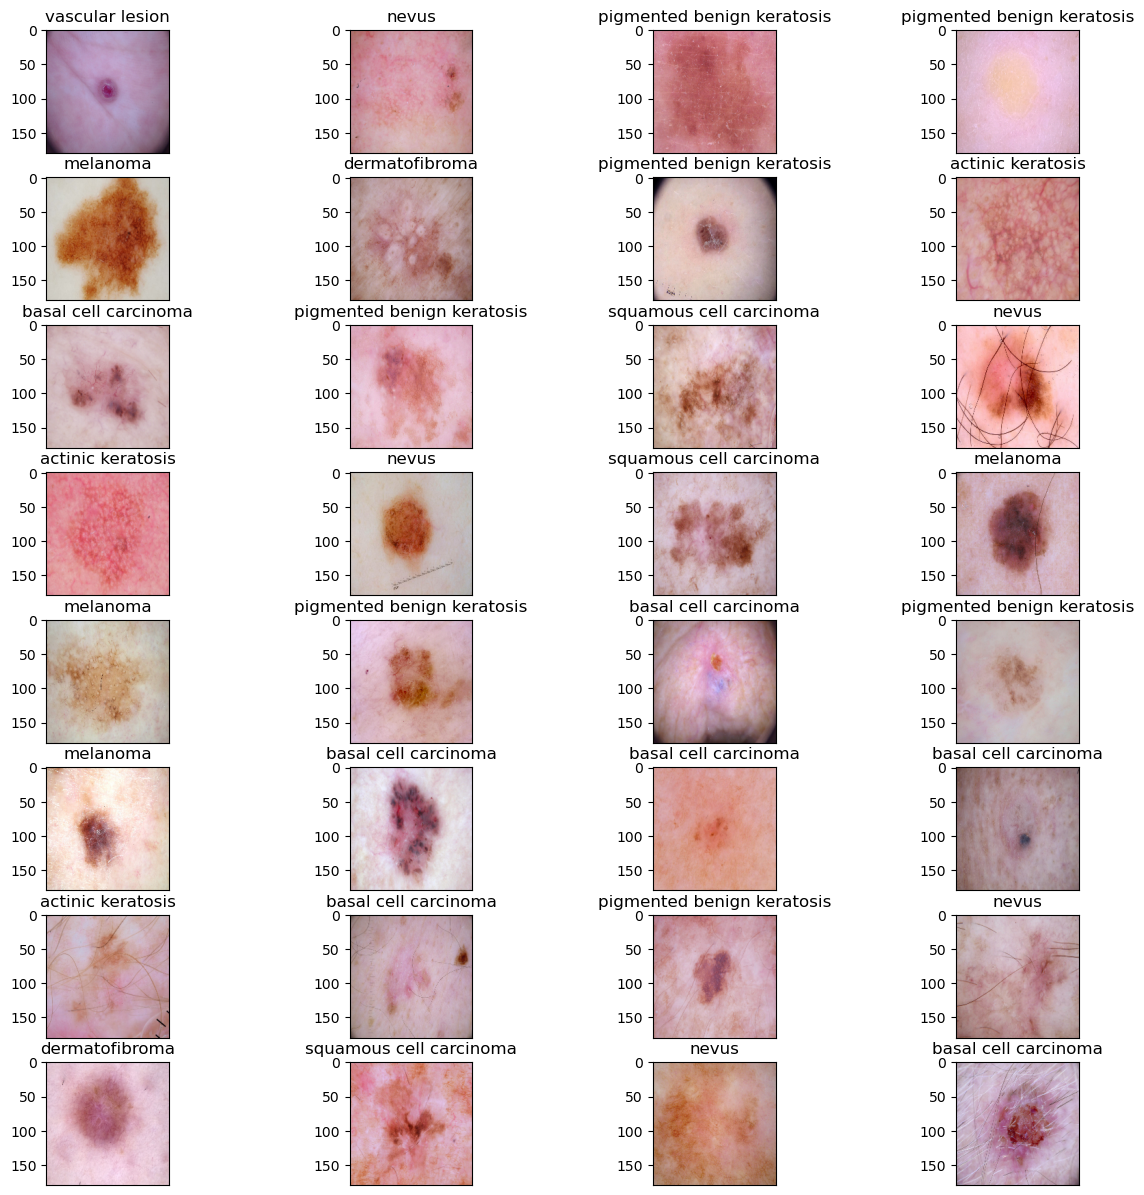

In [9]:
# lets inspect some of the images by visualizing

for batch in train_ds:
    plt.figure(figsize=(15,15))
    images = batch[0]
    labels = batch[1]
    for i in range(len(labels)):
        plt.subplot(8, 4,i+1)
        plt.imshow(tf.cast(images[i],dtype=tf.uint32))
        plt.title(train_ds.class_names[labels[i]])
        plt.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### We are Creating a CNN model, which can accurately detect 9 classes present in the dataset. We Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
#CNN Model 

#Sequential model with  first Rescaling layer
model = Sequential([
                    layers.Rescaling(1./255,input_shape=(180,180,3))
])

# 1 Conv layer with 1 MaxPool Layer (1st CNN layer)
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# 1 Conv layer with 1 MaxPool Layer (2nd CNN layer)
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# 1 Conv layer with 1 MaxPool Layer (3rd CNN layer)
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer 
model.add(layers.Dropout(0.5))

#Flatten Layer 
model.add(layers.Flatten())

# Fully Connected Dense Layer 
model.add(layers.Dense(128,activation='relu'))

#Dropout layer 
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
model.add(layers.Dense(9, activation='softmax'))

C:\Users\sandy\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
We are Choosing an appropirate optimiser and loss function for model training 

In [12]:
### Lets choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
# lets fit the model so the training starts

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


C:\Users\sandy\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 653ms/step - accuracy: 0.1695 - loss: 2.3552 - val_accuracy: 0.2036 - val_loss: 2.0377
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 627ms/step - accuracy: 0.2573 - loss: 1.9418 - val_accuracy: 0.4094 - val_loss: 1.6954
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 665ms/step - accuracy: 0.4004 - loss: 1.7112 - val_accuracy: 0.4072 - val_loss: 1.6137
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 704ms/step - accuracy: 0.3856 - loss: 1.6618 - val_accuracy: 0.3803 - val_loss: 1.7016
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 709ms/step - accuracy: 0.4154 - loss: 1.6251 - val_accuracy: 0.4273 - val_loss: 1.5596
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.4538 - loss: 1.5213 - val_accuracy: 0.4407 - val_loss: 1.5258
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 698ms/step - accuracy: 0.5182 - loss: 1.3935 - val_accuracy: 0.4877 - val_loss: 1.4387
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 708ms/step - accuracy: 0.4892 - loss: 1.4444 - val_accuracy: 0.523

### Visualizing training results

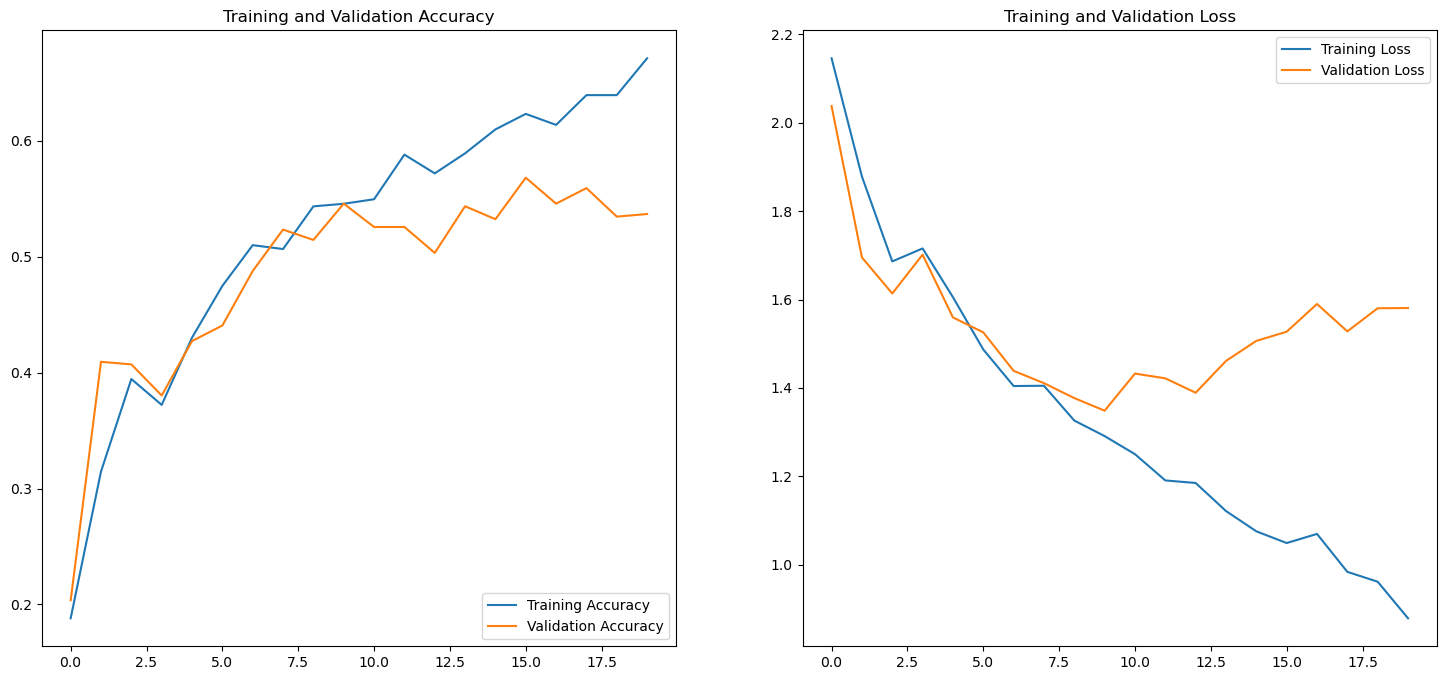

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As we can see from the graph, there is a clear indication of model overfitting as the training accuracy is very high compared to validation accuracy and the difference between them is too high which denotes overfitting.

### Now, we will try to run the same model we have built before including a BatchNormalization layer. As we know, Batch Normalization layer helps avoid overfitting of the model.
### Create the model, compile and train the model


In [17]:
model = keras.Sequential([
                          layers.Rescaling(1./255,input_shape=(180,180,3)),
    layers.RandomFlip(mode="horizontal_and_vertical"),
                             layers.RandomRotation(0.2),
                             layers.RandomZoom(height_factor=(0.3), width_factor=(0.3))
])



In [36]:
#CNN Model 

#Sequential model with  first Rescaling layer
model = Sequential([
                    layers.Rescaling(1./255,input_shape=(180,180,3))
])

# 1 Conv layer with 1 MaxPool Layer (1st CNN layer)
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


# 1 Conv layer with 1 MaxPool Layer (2nd CNN layer)
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


# 1 Conv layer with 1 MaxPool Layer (3rd CNN layer)
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Dropout layer 
model.add(layers.Dropout(0.5))

#Flatten Layer 
model.add(layers.Flatten())

# Fully Connected Dense Layer 
model.add(layers.Dense(128,activation='relu'))
model.add(layers.BatchNormalization())

#Dropout layer 
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
model.add(layers.Dense(9, activation='softmax'))

### Compiling the model

In [37]:
### Lets choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [38]:
# Train the model

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 591ms/step - accuracy: 0.2462 - loss: 2.2484 - val_accuracy: 0.1499 - val_loss: 3.8183
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 599ms/step - accuracy: 0.4100 - loss: 1.6676 - val_accuracy: 0.2729 - val_loss: 2.5092
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 601ms/step - accuracy: 0.4932 - loss: 1.5066 - val_accuracy: 0.4609 - val_loss: 1.5348
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 602ms/step - accuracy: 0.5110 - loss: 1.4364 - val_accuracy: 0.4295 - val_loss: 1.7643
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 602ms/step - accuracy: 0.5391 - loss: 1.3752 - val_accuracy: 0.4228 - val_loss: 2.2523
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 604ms/step - accuracy: 0.5404 - loss: 1.2840 - val_accuracy: 0.4787 - val_loss: 1.5568
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 599ms/step - accuracy: 0.5520 - loss: 1.2762 - val_accuracy: 0.4989 - val_loss: 1.5982
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - accuracy: 0.5557 - loss: 1.2110 - val_accu

### Visualizing the results

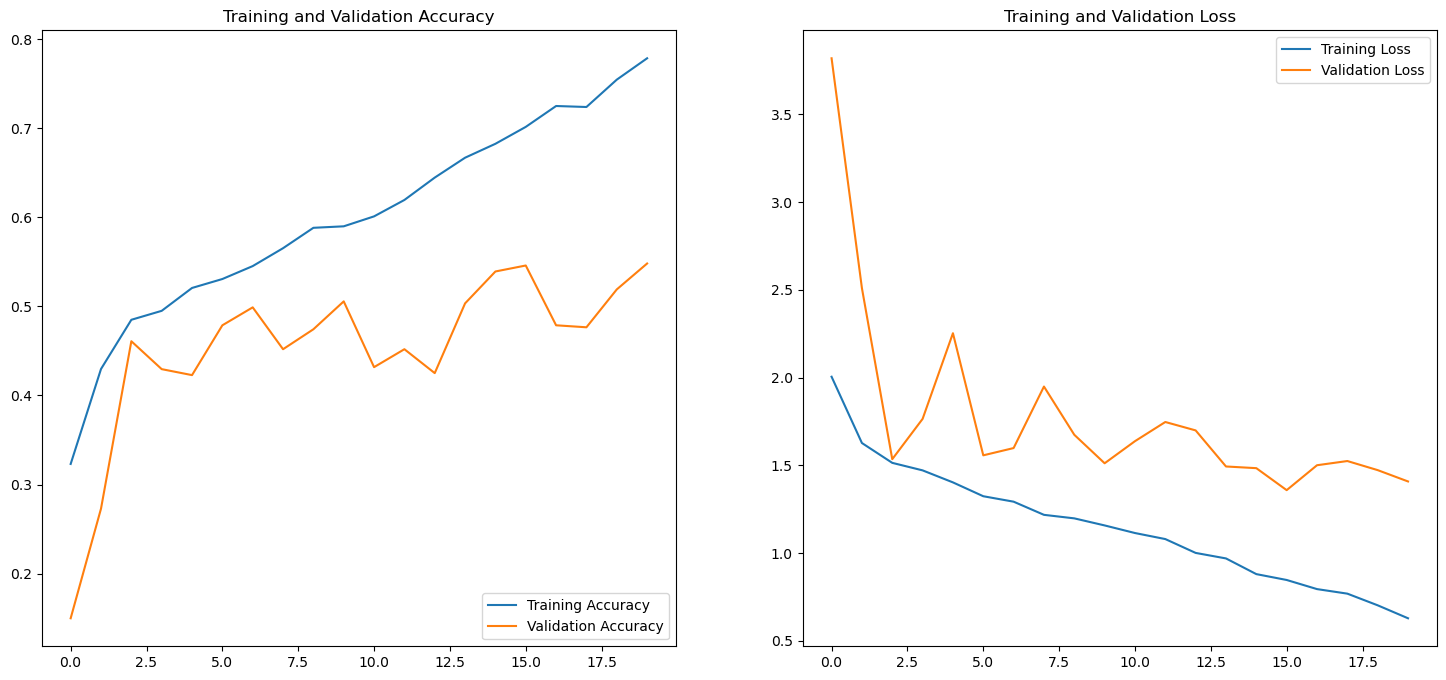

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As we saw, the accuracy of the train data has come down significantly, this shows that the batch normalization has helped and we can see near similar accuracy for both train and validation data.

#### Lets find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [43]:
# we are writting a function to check Class Imbalance

def class_distribution_count(directory):

    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

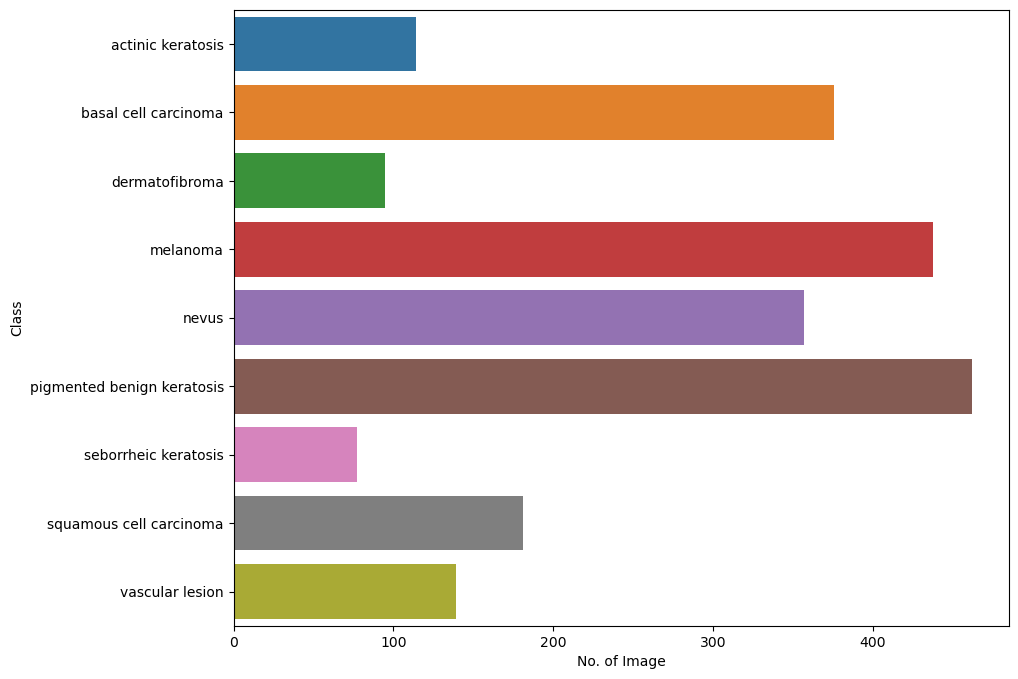

In [44]:
df = class_distribution_count(data_dir_train)
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")
plt.show()

In [45]:
countList=[]
classList=[]
for i in class_names:   
    count = 0
    for j in data_dir_train.glob(i+'/*.jpg'):
        count += 1
    classList.append(i)
    countList.append(count)

In [46]:
df= pd.DataFrame({'class':classList,'count':countList})
df

,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


#### : Lets see some info about the class
#### - Which class has the least number of samples?
#### ------ Ans :  'seborrheic keratosis' has the least number of samples with 77 samples in training data
#### - Which classes dominate the data in terms proportionate number of samples?
#### ------ Ans :  'pigmented benign keratosis' has the Most number of samples with 462 samples in training data

#### Lets rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# Install Augmentor. Run this only once

!pip install Augmentor

In [47]:
# Pipeline to use Augmentor and create images in train dataset to resolve class imbalance

path_to_training_dataset= "C:\\Users\\sandy\\Downloads\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FB39653B90>: 100%|██████████| 500/500 [00:04<00:00, 115.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FB39672110>: 100%|██████████| 500/500 [00:04<00:00, 112.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB391EB150>: 100%|██████████| 500/500 [00:04<00:00, 111.09 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1FB39601350>: 100%|██████████| 500/500 [00:21<00:00, 22.87 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1FB3933FB50>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FB3965DA50>: 100%|██████████| 500/500 [00:04<00:00, 108.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1FB35427290>: 100%|██████████| 500/500 [00:10<00:00, 46.43 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB392FD1D0>: 100%|██████████| 500/500 [00:04<00:00, 106.87 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\sandy\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB39342650>: 100%|██████████| 500/500 [00:04<00:00, 112.21 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [48]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


###  Train the model on the data created using Augmentor

In [49]:
# We create train and validation data set again after augmentation so we can build a new model

batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [50]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a Validation dataset

In [51]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [53]:
#CNN Model 

#Sequential model with  first Rescaling layer
model = Sequential([
                    layers.Rescaling(1./255,input_shape=(180,180,3))
])

# 1 Conv layer with 1 MaxPool Layer (1st CNN layer)
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# 1 Conv layer with 1 MaxPool Layer (2nd CNN layer)
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# 1 Conv layer with 1 MaxPool Layer (3rd CNN layer)
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer 
model.add(layers.Dropout(0.5))

#Flatten Layer 
model.add(layers.Flatten())

# Fully Connected Dense Layer 
model.add(layers.Dense(128,activation='relu'))

#Dropout layer 
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
model.add(layers.Dense(9, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

####  Compile your model (Choose optimizer and loss function appropriately)

In [55]:
# Compile the model

model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=['accuracy'])

####  Train your model

In [56]:
# Fit the model

history = model.fit(train_ds, validation_data=val_ds, epochs=30
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 115s 656ms/step - accuracy: 0.1963 - loss: 2.0904 - val_accuracy: 0.3808 - val_loss: 1.5707
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 112s 661ms/step - accuracy: 0.3738 - loss: 1.6095 - val_accuracy: 0.4150 - val_loss: 1.5041
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 697ms/step - accuracy: 0.4408 - loss: 1.4534 - val_accuracy: 0.4714 - val_loss: 1.3675
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 111s 653ms/step - accuracy: 0.4917 - loss: 1.3366 - val_accuracy: 0.5397 - val_loss: 1.2661
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 113s 669ms/step - accuracy: 0.5418 - loss: 1.2119 - val_accuracy: 0.5687 - val_loss: 1.1627
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.6022 - loss: 1.0550 - val_accuracy: 0.6288 - val_loss: 1.0040
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 136s 804ms/step - accuracy: 0.6642 - loss: 0.9283 - val_accuracy: 0.6102 - val_loss: 1.0578
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 151s 891ms/step - accuracy: 0.6676 - lo

####   Visualize the model results

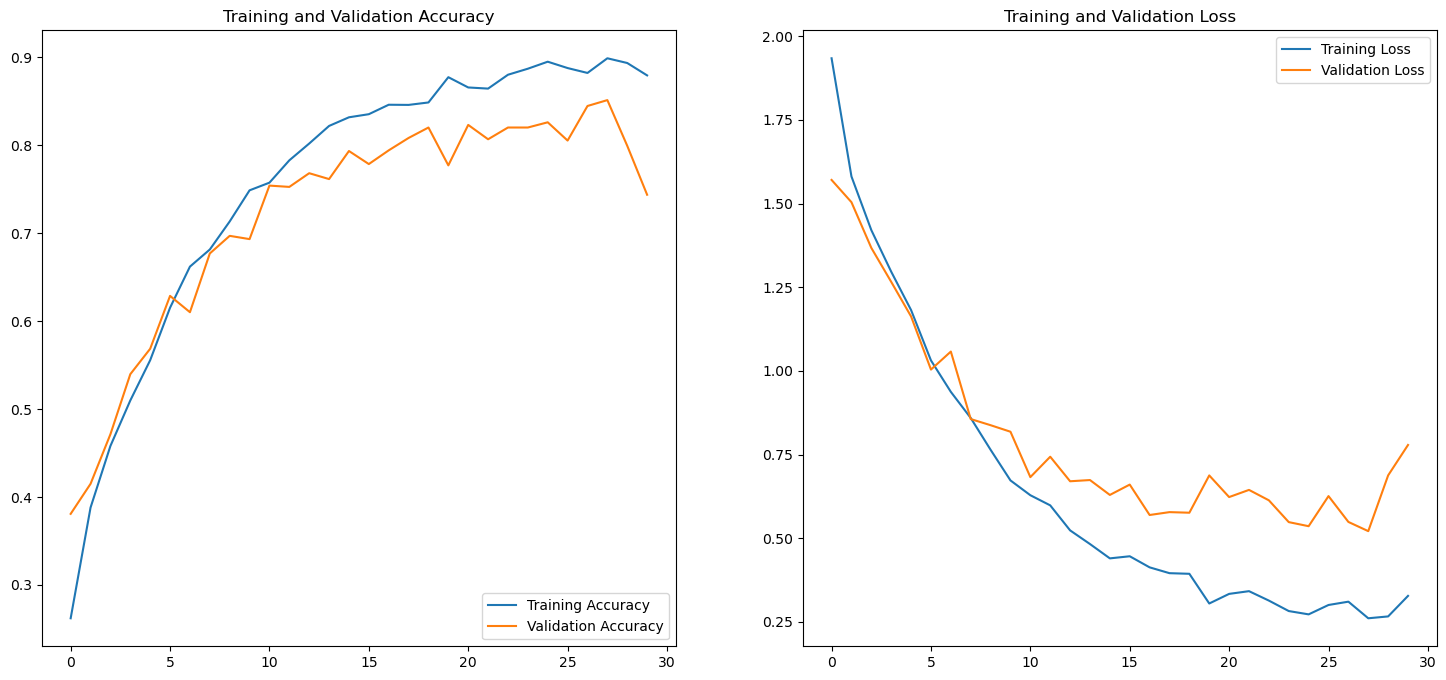

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Lets Analyze our results here. Did we get rid of underfitting/overfitting? Did class rebalance help?

#### Ans-- Yes, our analysis indicates that we've effectively addressed both underfitting and overfitting. By comparing the training accuracy of 0.8778 to the validation accuracy of 0.8404, we observe a close alignment, suggesting that overfitting and underfitting have been mitigated. Moreover, when contrasting the model's performance before and after class rebalancing, it's evident that rebalancing the classes has positively impacted the results. Therefore, we can confidently affirm that class rebalancing has indeed contributed to the improvement.

